# the Chennai Water Supply Manager 
 (v4.1: The Chembarambaakam LSTM model)

# STEP 0: Prepare
1. Import libraries
2. Download data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



pristine=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\reverse_df.xlsx - Chembarambaakam.csv',parse_dates={'date' : ['Date']},na_values=-1)


pristine=pristine.dropna()


pristine.reset_index(drop=True, inplace=True)
pristine['date']=pd.to_datetime(pristine['date'], format='%d/%m/%y').dt.strftime('%d/%m/%y')


originals=pristine
pristine.head(10)


,date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs)
0,01/01/04,0,0.0,0.0,0.0,0.0
1,01/02/04,1,0.0,0.0,0.0,0.0
2,01/03/04,2,0.0,0.0,0.0,0.0
3,01/04/04,3,0.0,0.0,0.0,0.0
4,01/05/04,4,0.0,0.0,0.0,0.0
5,01/06/04,5,0.0,0.0,0.0,0.0
6,01/07/04,6,0.0,0.0,0.0,0.0
7,01/08/04,7,0.0,0.0,0.0,0.0
8,01/09/04,8,0.0,0.0,0.0,0.0
9,01/10/04,9,0.0,0.0,0.0,0.0


In [30]:
pristine.isnull().sum()


date                0
nth day in year     0
Storage (mcft)      0
Inflow (cusecs)     0
Rainfall (mm)       0
Outflow (cusecs)    0
dtype: int64

# STEP 1: PREPROCESSING

1. remove duplicates
2. drop unnecessary columns
3. normalise data(v0: MinMax)
4. prepare sequence dataset
5. train-test split

In [36]:
raw=pristine
raw=raw.drop(columns=['date','nth day in year'])
'''
cols=['Storage (mcft)', 'Inflow (cusecs)', 'Rainfall (mm)']
for i in cols:
    maxx=max(raw[i])
    minn=min(raw[i])
    raw[i]-=minn
    raw[i]/=(maxx-minn)
raw.describe()'''

"\ncols=['Storage (mcft)', 'Inflow (cusecs)', 'Rainfall (mm)']\nfor i in cols:\n    maxx=max(raw[i])\n    minn=min(raw[i])\n    raw[i]-=minn\n    raw[i]/=(maxx-minn)\nraw.describe()"

In [37]:
#FEATURE EXTRACTION: Prepare sequence



'''
 day n outflow
    
    
    
 5 days dependant   '''
lookback=5
sequence=np.zeros(((len(raw)-lookback),lookback,raw.shape[-1]))
target=np.zeros(len(raw)-lookback)

for i in range(lookback, len(raw)):
    for j in range(0,lookback):
        sequence[i-lookback][j]=raw.loc[i+j-lookback,:]
    target[i-lookback]=raw['Outflow (cusecs)'][i]

In [38]:
pristine.loc[5000:5005,:]

,date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs)
5000,10/05/17,277,298.0,213.0,2.0,40.0
5001,10/06/17,278,310.0,177.0,6.0,38.0
5002,10/07/17,279,319.0,142.0,0.0,38.0
5003,10/08/17,280,323.0,79.0,0.0,33.0
5004,10/09/17,281,323.0,30.0,0.0,30.0
5005,10/10/17,282,320.0,0.0,0.0,36.0


In [39]:
pristine.tail()

,date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs)
5083,27/12/17,360,1863.0,0.0,0.0,49.0
5084,28/12/17,361,1859.0,0.0,0.0,49.0
5085,29/12/17,362,1855.0,0.0,0.0,49.0
5086,30/12/17,363,1851.0,0.0,0.0,49.0
5087,31/12/17,364,1847.0,0.0,0.0,49.0


In [40]:
def train_test_split(sequence,target,boundary=4380):
    if(boundary<1):
        x_train=sequence[:int(len(sequence)*boundary)]
        x_test=sequence[int(len(sequence)*boundary):]
        y_train=target[:int(len(target)*boundary)]
        y_test=target[int(len(target)*boundary):]
    else:
        x_train=sequence[:boundary]
        x_test=sequence[boundary:]
        y_train=target[:boundary]
        y_test=target[boundary:]
    
    return x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test=train_test_split(sequence,target)
print(x_train.shape,
    x_test.shape,
    y_train.shape,
    y_test.shape)

(4380, 5, 4) (703, 5, 4) (4380,) (703,)


# STEP 2: Model building

v0: Classic LSTM 

## Mv0: Classic LSTM

* LSTM-Dense model (32-1)

In [41]:
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
model=models.Sequential()
model.add(layers.LSTM(32,
                        dropout=0.1,
                        recurrent_dropout=0.5,
                        #return_sequences=True,
                        input_shape=(x_train.shape[1], x_train.shape[2])))

'''model.add(layers.LSTM(100, 
                        dropout=0.1,
                        recurrent_dropout=0.5))
                        '''
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer=optimizers.RMSprop())

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                4736      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=64, 
                    validation_data=(x_test, y_test))

Train on 4380 samples, validate on 703 samples
Epoch 1/200
4380/4380 [==============================] - 5s 1ms/sample - loss: 128.1749 - val_loss: 99.6612
Epoch 2/200
4380/4380 [==============================] - 0s 95us/sample - loss: 127.1700 - val_loss: 98.8158
Epoch 3/200
4380/4380 [==============================] - 0s 114us/sample - loss: 126.5740 - val_loss: 98.0439
Epoch 4/200
4380/4380 [==============================] - 0s 92us/sample - loss: 125.7550 - val_loss: 96.9608
Epoch 5/200
4380/4380 [==============================] - 0s 89us/sample - loss: 124.9064 - val_loss: 96.0410
Epoch 6/200
4380/4380 [==============================] - 0s 100us/sample - loss: 124.0432 - val_loss: 94.6580
Epoch 7/200
4380/4380 [==============================] - 0s 104us/sample - loss: 122.9376 - val_loss: 93.8715
Epoch 8/200
4380/4380 [==============================] - 0s 94us/sample - loss: 122.3175 - val_loss: 93.0608
Epoch 9/200
4380/4380 [==============================] - 0s 90us/sample - loss:

4380/4380 [==============================] - 0s 92us/sample - loss: 74.7922 - val_loss: 39.6331
Epoch 76/200
4380/4380 [==============================] - 0s 91us/sample - loss: 74.7096 - val_loss: 37.9948
Epoch 77/200
4380/4380 [==============================] - 0s 90us/sample - loss: 74.3060 - val_loss: 37.5999
Epoch 78/200
4380/4380 [==============================] - 0s 88us/sample - loss: 73.8527 - val_loss: 36.1256
Epoch 79/200
4380/4380 [==============================] - 0s 86us/sample - loss: 73.5330 - val_loss: 39.8473
Epoch 80/200
4380/4380 [==============================] - 0s 87us/sample - loss: 73.4895 - val_loss: 35.0450
Epoch 81/200
4380/4380 [==============================] - 0s 87us/sample - loss: 73.2659 - val_loss: 34.6831
Epoch 82/200
4380/4380 [==============================] - 0s 88us/sample - loss: 72.5963 - val_loss: 34.3804
Epoch 83/200
4380/4380 [==============================] - 0s 90us/sample - loss: 72.8649 - val_loss: 34.7517
Epoch 84/200
4380/4380 [========

4380/4380 [==============================] - 0s 87us/sample - loss: 66.7900 - val_loss: 21.4689
Epoch 150/200
4380/4380 [==============================] - 0s 88us/sample - loss: 66.3773 - val_loss: 18.8130
Epoch 151/200
4380/4380 [==============================] - 0s 86us/sample - loss: 66.7505 - val_loss: 19.2872
Epoch 152/200
4380/4380 [==============================] - 0s 87us/sample - loss: 65.8446 - val_loss: 16.0835
Epoch 153/200
4380/4380 [==============================] - 0s 87us/sample - loss: 66.5723 - val_loss: 15.5077
Epoch 154/200
4380/4380 [==============================] - 0s 86us/sample - loss: 65.7029 - val_loss: 16.2718
Epoch 155/200
4380/4380 [==============================] - 0s 87us/sample - loss: 65.5672 - val_loss: 20.1838
Epoch 156/200
4380/4380 [==============================] - 0s 86us/sample - loss: 66.1351 - val_loss: 20.0099
Epoch 157/200
4380/4380 [==============================] - 0s 86us/sample - loss: 66.0757 - val_loss: 17.0904
Epoch 158/200
4380/4380 

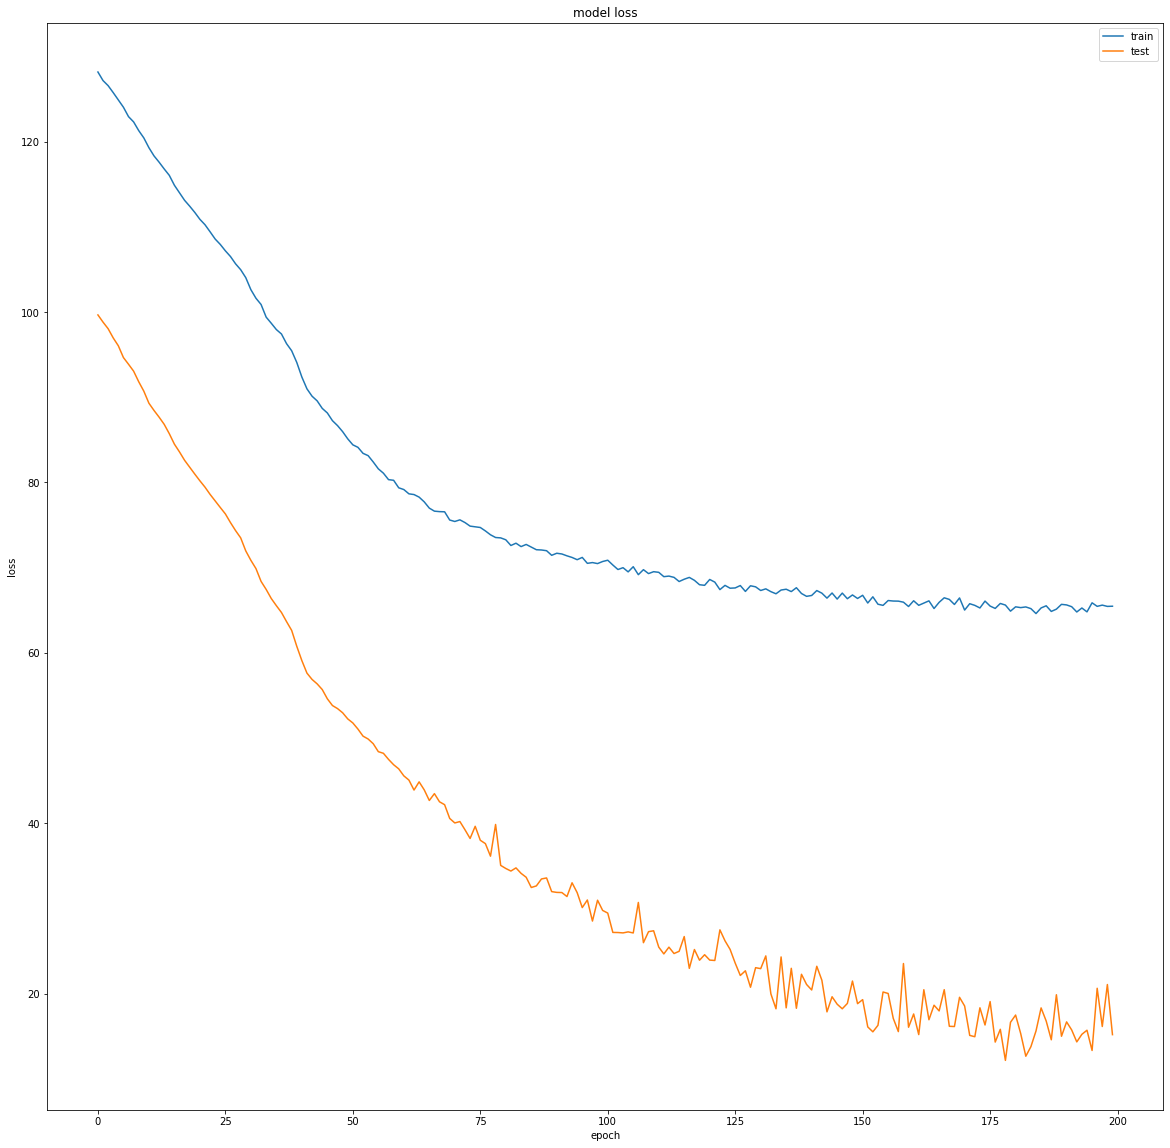

In [43]:
plt.figure(figsize=(20,20))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [14]:
lookback


5

In [15]:

output

array([[44.73557]], dtype=float32)

In [16]:
pristine.loc[len(pristine)-1:end+lookback-1,'Outflow (cusecs)']

5087    49.0
Name: Outflow (cusecs), dtype: float64

In [91]:
start=3999
end=4300

s1=start+1
e1=end+1

In [92]:
len(model.predict(sequence[s1:e1])),len(model.predict(sequence[start:end]))

(301, 301)

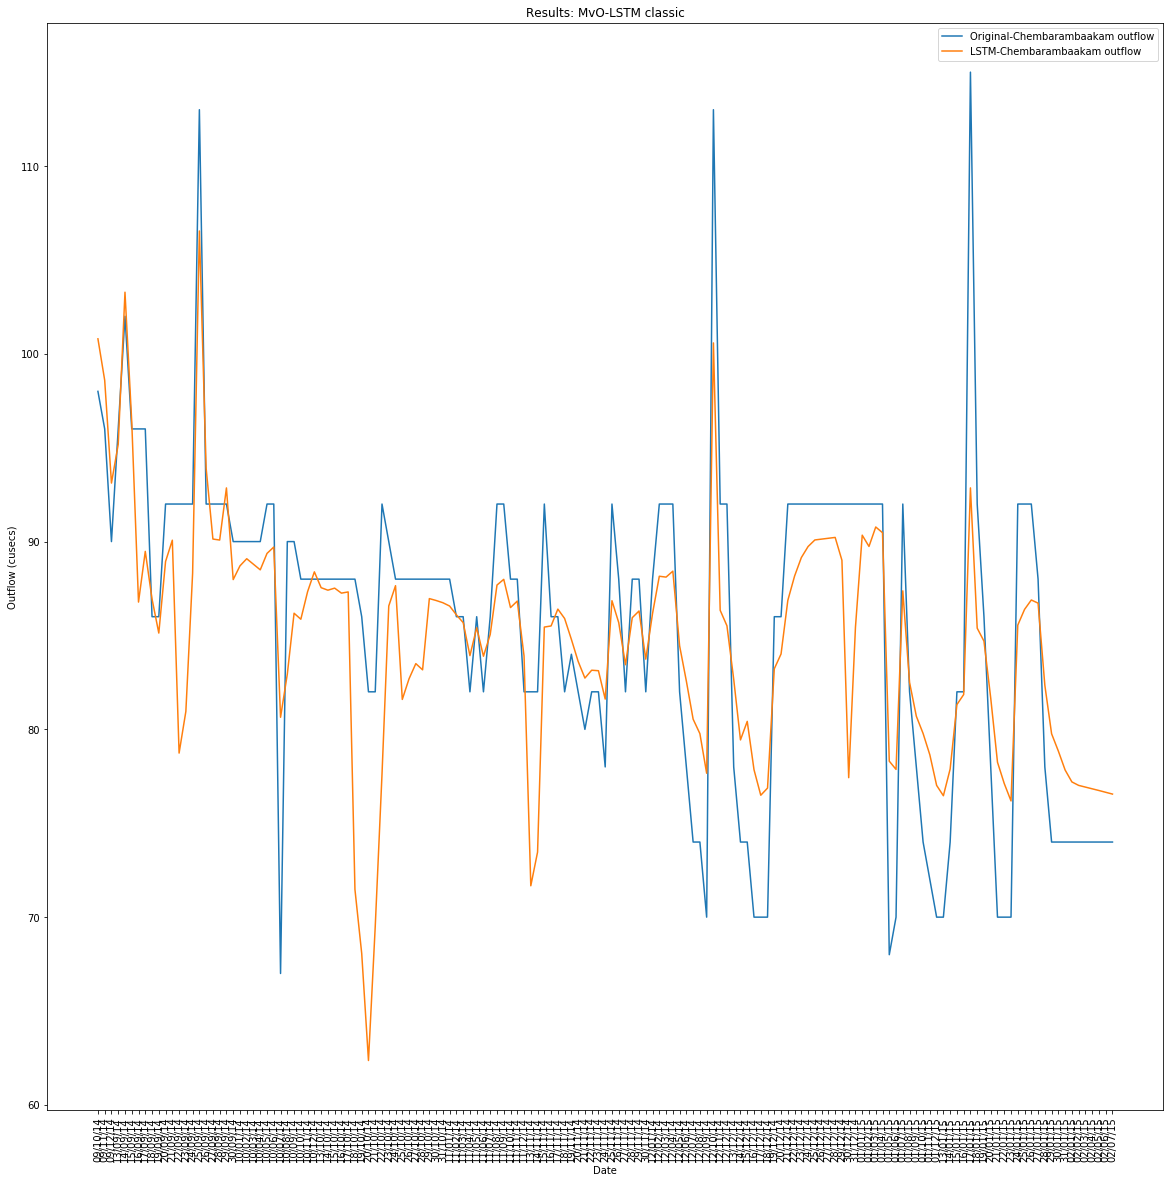

In [44]:
start=3899
end=4050

s1=start+1
e1=end+1
output=model.predict(sequence[s1:e1])
plt.figure(figsize=(20,20))
plt.plot(pristine.loc[start+lookback:end+lookback-1,'date'].values,pristine.loc[start+lookback:end+lookback-1,['Outflow (cusecs)']].values,label='Original-Chembarambaakam outflow')
plt.plot(pristine.loc[start+lookback:end+lookback-1,'date'].values,output,label='LSTM-Chembarambaakam outflow')
plt.xticks(rotation=90)
plt.legend()
plt.title('Results: MvO-LSTM classic')
plt.ylabel('Outflow (cusecs)')
plt.xlabel('Date')
#plt.legend('Original-Chembarambaakam outflow','LSTM-Chembarambaakam outflow')
plt.savefig('D:\\Semester 4\\Soft Computing\\Chennai Water Supply Manager\\v0.jpeg')
plt.show()

In [18]:
#TEST DATA Performance
pristest=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\reverse_df.xlsx - ChembarambaakamTest.csv',parse_dates={'date' : ['Date']},na_values=-1)
pristest['date']=pd.to_datetime(pristest['date'], format='%d/%m/%y').dt.strftime('%d/%m/%y')


pristest=pristest.dropna()


pristest.reset_index(drop=True, inplace=True)
pristest.head()

,date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs)
0,01/01/18,0,1842.0,0.0,0.0,57.0
1,01/02/18,1,1837.0,0.0,0.0,56.0
2,01/03/18,2,1832.0,0.0,0.0,56.0
3,01/04/18,3,1827.0,0.0,0.0,56.0
4,01/05/18,4,1822.0,0.0,0.0,55.0


In [11]:
sequence.to_csv('h.csv')

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [111]:
import tensorflow
input_tensor = layers.Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)
model = tensorflow.keras.Model(input_tensor, output_tensor)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


In [7]:

s2=sequence.astype(np.float32)
y=model(s2[4998:5002])

In [8]:
y.numpy()

array([[38.07717 ],
       [33.794506],
       [30.749722],
       [35.462128]], dtype=float32)

In [21]:
#Sequence generator for Test data

test=pristest
test=test.drop(columns=['date','nth day in year'])

cols=['Storage (mcft)', 'Inflow (cusecs)', 'Rainfall (mm)']
for i in cols:
    maxx=max(pristine[i])
    minn=min(pristine[i])
    pristest[i]-=minn
    pristest[i]/=(maxx-minn)
pristest.info()

lookback=5
sequence=np.zeros(((len(test)-lookback),lookback,test.shape[-1]))
target=np.zeros(len(test)-lookback)

for i in range(lookback, len(test)):
    for j in range(0,lookback):
        sequence[i-lookback][j]=test.loc[i+j-lookback,:]
    target[i-lookback]=test['Outflow (cusecs)'][i]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              728 non-null    object 
 1   nth day in year   728 non-null    int64  
 2   Storage (mcft)    728 non-null    float64
 3   Inflow (cusecs)   728 non-null    float64
 4   Rainfall (mm)     728 non-null    float64
 5   Outflow (cusecs)  728 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 34.2+ KB


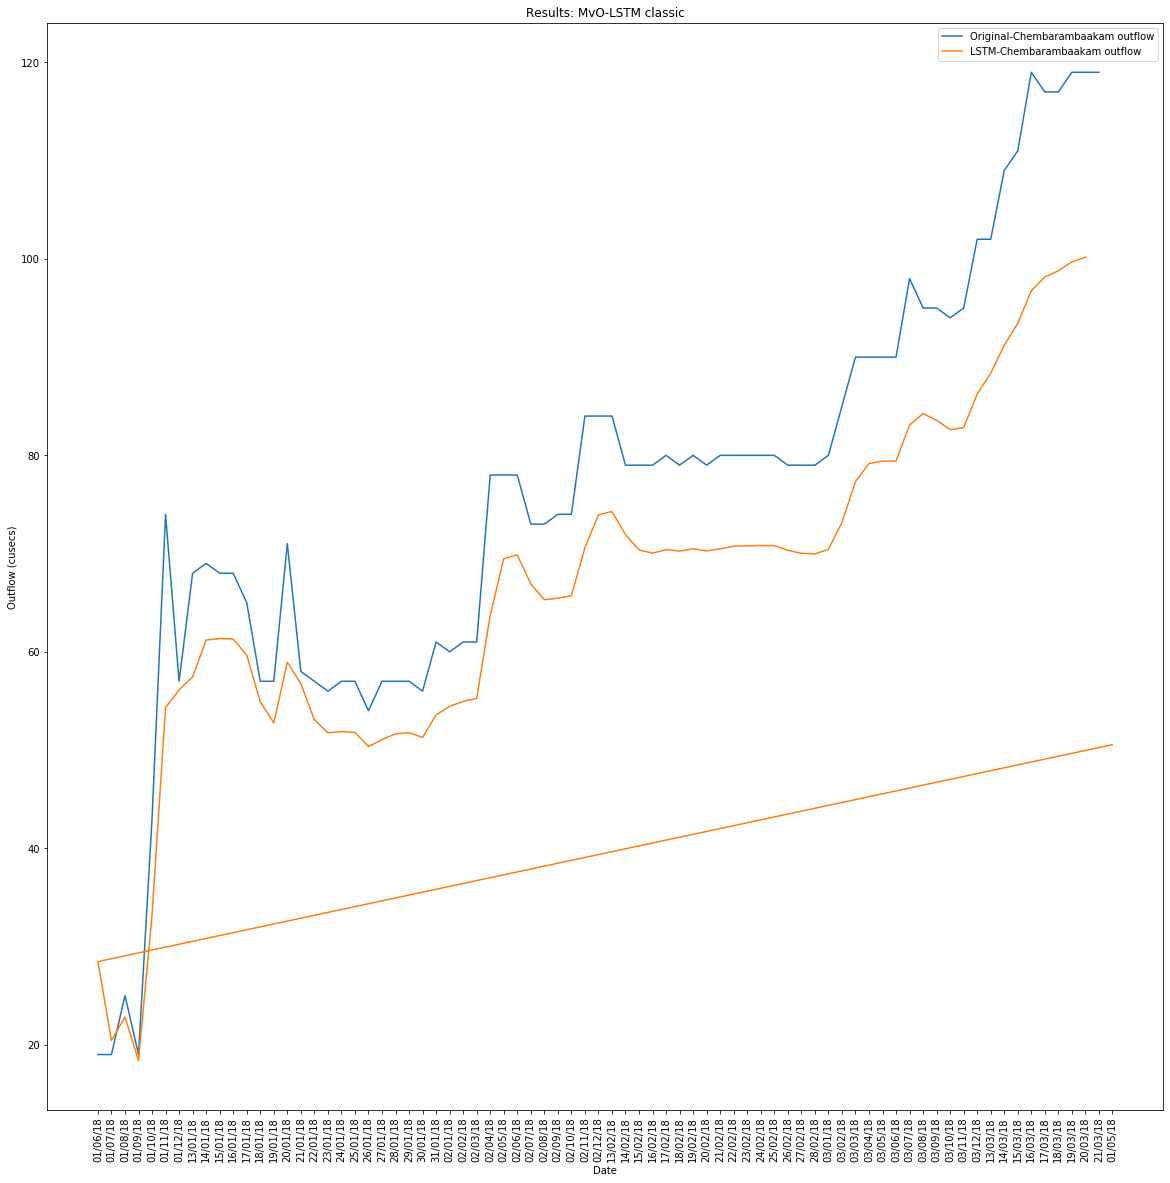

In [26]:
start=0
end=75
output=model.predict(sequence[start:end])


plt.figure(figsize=(20,20))
plt.plot(pristest.loc[start+lookback:end+lookback-1,'date'].values,pristest.loc[start+lookback:end+lookback-1,['Outflow (cusecs)']].values,label='Original-Chembarambaakam outflow')
plt.plot(pristest.loc[start+lookback-1:end+lookback-2,'date'].values,output,label='LSTM-Chembarambaakam outflow')
plt.xticks(rotation=90)
plt.legend()
plt.title('Results: MvO-LSTM classic')
plt.ylabel('Outflow (cusecs)')
plt.xlabel('Date')
#plt.legend('Original-Chembarambaakam outflow','LSTM-Chembarambaakam outflow')
plt.savefig('D:\\Semester 4\\Soft Computing\\Chennai Water Supply Manager\\v0test.jpeg')
plt.show()

In [23]:
sequence[0]

array([[ 0.54240283,  0.        ,  0.        , 57.        ],
       [ 0.54093051,  0.        ,  0.        , 56.        ],
       [ 0.53945819,  0.        ,  0.        , 56.        ],
       [ 0.53798587,  0.        ,  0.        , 56.        ],
       [ 0.53651355,  0.        ,  0.        , 55.        ]])

In [ ]:
pristest.loc[lookback-1,:]

In [68]:
output[0]

array([27.488441], dtype=float32)

## Data Visualisation Graphs

Stufy more about the spread of data.

In [3]:
import pandas as pd
spice=pd.read_csv('D:\Semester 4\Soft Computing\Chennai Water Supply Manager\\reverse_df.csv',parse_dates={'date' : ['Date']})

spice['date']=pd.to_datetime(spice['date'], format='%d/%m/%y').dt.strftime('%d/%m/%y')
spice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20392 entries, 0 to 20391
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              20392 non-null  object 
 1   nth day in year   20392 non-null  int64  
 2   Storage (mcft)    20392 non-null  float64
 3   Inflow (cusecs)   20392 non-null  float64
 4   Rainfall (mm)     20392 non-null  float64
 5   Outflow (cusecs)  20392 non-null  float64
 6   Reservoir         20392 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 1.1+ MB


In [21]:
spice.head()

,date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs),Reservoir
0,01/01/04,0,3.9,0.0,0.0,0.0,1
1,01/01/04,0,0.0,0.0,0.0,0.0,2
2,01/01/04,0,268.0,10.0,0.0,10.0,3
3,01/01/04,0,0.0,0.0,0.0,0.0,4
4,01/02/04,1,3.9,0.0,0.0,0.0,1


In [2]:
date=list()
total=list()
i=0
while(True):
    date.append(spice.loc[i,'date'])
    total.append(spice.loc[i,'Outflow (cusecs)']+spice.loc[i+1,'Outflow (cusecs)']+spice.loc[i+2,'Outflow (cusecs)']+spice.loc[i+3,'Outflow (cusecs)'])
    i+=4
    if(i>=len(spice)):
        break
new=pd.DataFrame(columns=['date','total'])
new['date']=date
new['total']=total

new['date']=pd.to_datetime(new['date'], format='%d/%m/%y').dt.strftime('%d/%m/%y')


In [43]:
new.tail(40)


,date,total
5058,22/11/17,141.0
5059,23/11/17,150.0
5060,24/11/17,152.0
5061,25/11/17,158.0
5062,26/11/17,158.0
5063,27/11/17,158.0
5064,28/11/17,162.0
5065,29/11/17,162.0
5066,30/11/17,163.0
5067,12/01/17,162.0


In [7]:
dryout=0
count=0
new.describe()
for i in new['total']:
    if(i<480):
        #dryout+=(480-i)
        #count+=1
        ;
    elif (i>1000):
        dryout+=(i-480)
        count+=1

        
print(count,(count/len(new))*100,dryout,dryout/count)

152 2.981561396626128 733974.0 4828.776315789473


In [7]:
reset=0
c=0
maxx=len(volga)
for i in range(0,maxx):
    if(i>=len(volga)):
        break
    if(volga.loc[i,'Reservoir']==1 and volga.loc[i+1,'Reservoir']==2 and volga.loc[i+2,'Reservoir']==3 and volga.loc[i+3,'Reservoir']==4 ):
        i+=4
    else:
        while(True):
            volga=volga.drop(volga.index[i])
            volga.reset_index(drop=True, inplace=True)
            c+=1
            if(volga.loc[i,'Reservoir']==1):
                i-=1
                break

KeyError: 5113

In [40]:
plt.figure(figsize=(20,20))
plt.plot(df['date'],df['Outflow (cusecs)'])
plt.xticks(rotation=90)
plt.show()
plt.savefig('D:\\fig.jpeg')

NameError: name 'df' is not defined

<Figure size 1440x1440 with 0 Axes>

In [8]:
c

15342

In [9]:
volga.head()

,Date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs),Reservoir
0,02/01/2004,1,3.9,0.0,0.0,0.0,1
1,03/01/2004,2,3.9,0.0,0.0,0.0,1
2,04/01/2004,3,3.9,0.0,0.0,0.0,1
3,05/01/2004,4,3.8,0.0,0.0,0.0,1
4,06/01/2004,5,3.8,0.0,0.0,0.0,1


In [10]:
i=0
volga=volga.drop(volga.index[i])
volga.reset_index(drop=True, inplace=True)

In [11]:
volga.head()

,Date,nth day in year,Storage (mcft),Inflow (cusecs),Rainfall (mm),Outflow (cusecs),Reservoir
0,03/01/2004,2,3.9,0.0,0.0,0.0,1
1,04/01/2004,3,3.9,0.0,0.0,0.0,1
2,05/01/2004,4,3.8,0.0,0.0,0.0,1
3,06/01/2004,5,3.8,0.0,0.0,0.0,1
4,07/01/2004,6,3.8,0.0,0.0,0.0,1


In [ ]:
'''

for i in range(1990,2300):
    minn=min(df['Outflow (cusecs)'])
    maxx=max(df['Outflow (cusecs)'])
    v=1-(df['Outflow (cusecs)'][i]-minn)/(maxx-minn)
    df['Outflow (cusecs)'][i]=v'''


plt.figure(figsize=(20,20))
#plt.ylim(0.9999855,0.9999860)
plt.plot(df.loc[2000:2100,'date'],df.loc[2000:2100,'Outflow (cusecs)'])#-min(df['Outflow (cusecs)']))/(max(df['Outflow (cusecs)'])-min(df['Outflow (cusecs)'])))

plt.xticks(rotation=90)
plt.show()

plt.savefig('D:\\fig2.jpeg')

In [9]:
sequences

NameError: name 'sequences' is not defined